In [87]:
import os
import cv2
import json
import shutil
import random
import numpy as np
import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from src.create_annotations import *
from shapely.geometry import Polygon, MultiPolygon


In [61]:
# Label ids of the dataset
category_ids = {
    "non": 0,
    "affected": 1,
}

# Define which colors match which categories in the images
category_colors = {
    "(0, 0, 0)": 0, # normal
    "(255, 255, 255)": 1, # affected
}

# Define the ids that are a multipolygon.
multipolygon_ids = [1]

In [62]:
# Get "images" and "annotations" info
def images_annotations_info(maskpath):
    # This id will be automatically increased as we go
    annotation_id = 0
    image_id = 0
    annotations = []
    images = []
    
    for mask_image in glob.glob(maskpath + "*.png"):
        # The mask image is *.png but the original image is *.jpg.
        # We make a reference to the original file in the COCO JSON file
        original_file_name = os.path.basename(mask_image).split("_segmentation.")[0] + ".jpg"

        # Open the image and (to be sure) we convert it to RGB
        mask_image_open = Image.open(mask_image).convert("RGB")
        w, h = mask_image_open.size
        
        # "images" info 
        image = create_image_annotation(original_file_name, w, h, image_id)
        images.append(image)

        sub_masks = create_sub_masks(mask_image_open, w, h)
        has_class_1 = False
        for color, sub_mask in sub_masks.items():
            category_id = category_colors[color]

            # "annotations" info
            polygons, segmentations = create_sub_mask_annotation(sub_mask)

            # Check if we have classes that are a multipolygon
            if category_id in multipolygon_ids:
                # Combine the polygons to calculate the bounding box and area
                multi_poly = MultiPolygon(polygons)
                                
                annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

                annotations.append(annotation)
                annotation_id += 1
            else:
                for i in range(len(polygons)):
                    # Cleaner to recalculate this variable
                    segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]
                    
                    annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)
                    
                    annotations.append(annotation)
                    annotation_id += 1
                    if category_id == 1:
                        has_class_1 = True
        if not has_class_1:
            # Add a background annotation for the entire image
            annotation = create_annotation_format(Polygon([(0, 0), (w, 0), (w, h), (0, h)]), [[0, 0, w, 0, w, h, 0, h]], image_id, 0, annotation_id)
            annotations.append(annotation)
            annotation_id += 1

        image_id += 1
    return images, annotations, annotation_id



In [63]:
if __name__ == "__main__":
    # Get the standard COCO JSON format
    coco_format = get_coco_json_format()
    
    for keyword in ["input_images"]:
        mask_path = "dataset/{}_mask/".format(keyword)
        
        # Create category section
        coco_format["categories"] = create_category_annotation(category_ids)
    
        # Create images and annotations sections
        coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

        output_dir = "dataset/output/"
        os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

        with open(os.path.join(output_dir, "{}.json".format(keyword)), "w") as outfile:
            json.dump(coco_format, outfile)

        print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))


Created 19 annotations for images in folder: dataset/input_images_mask/


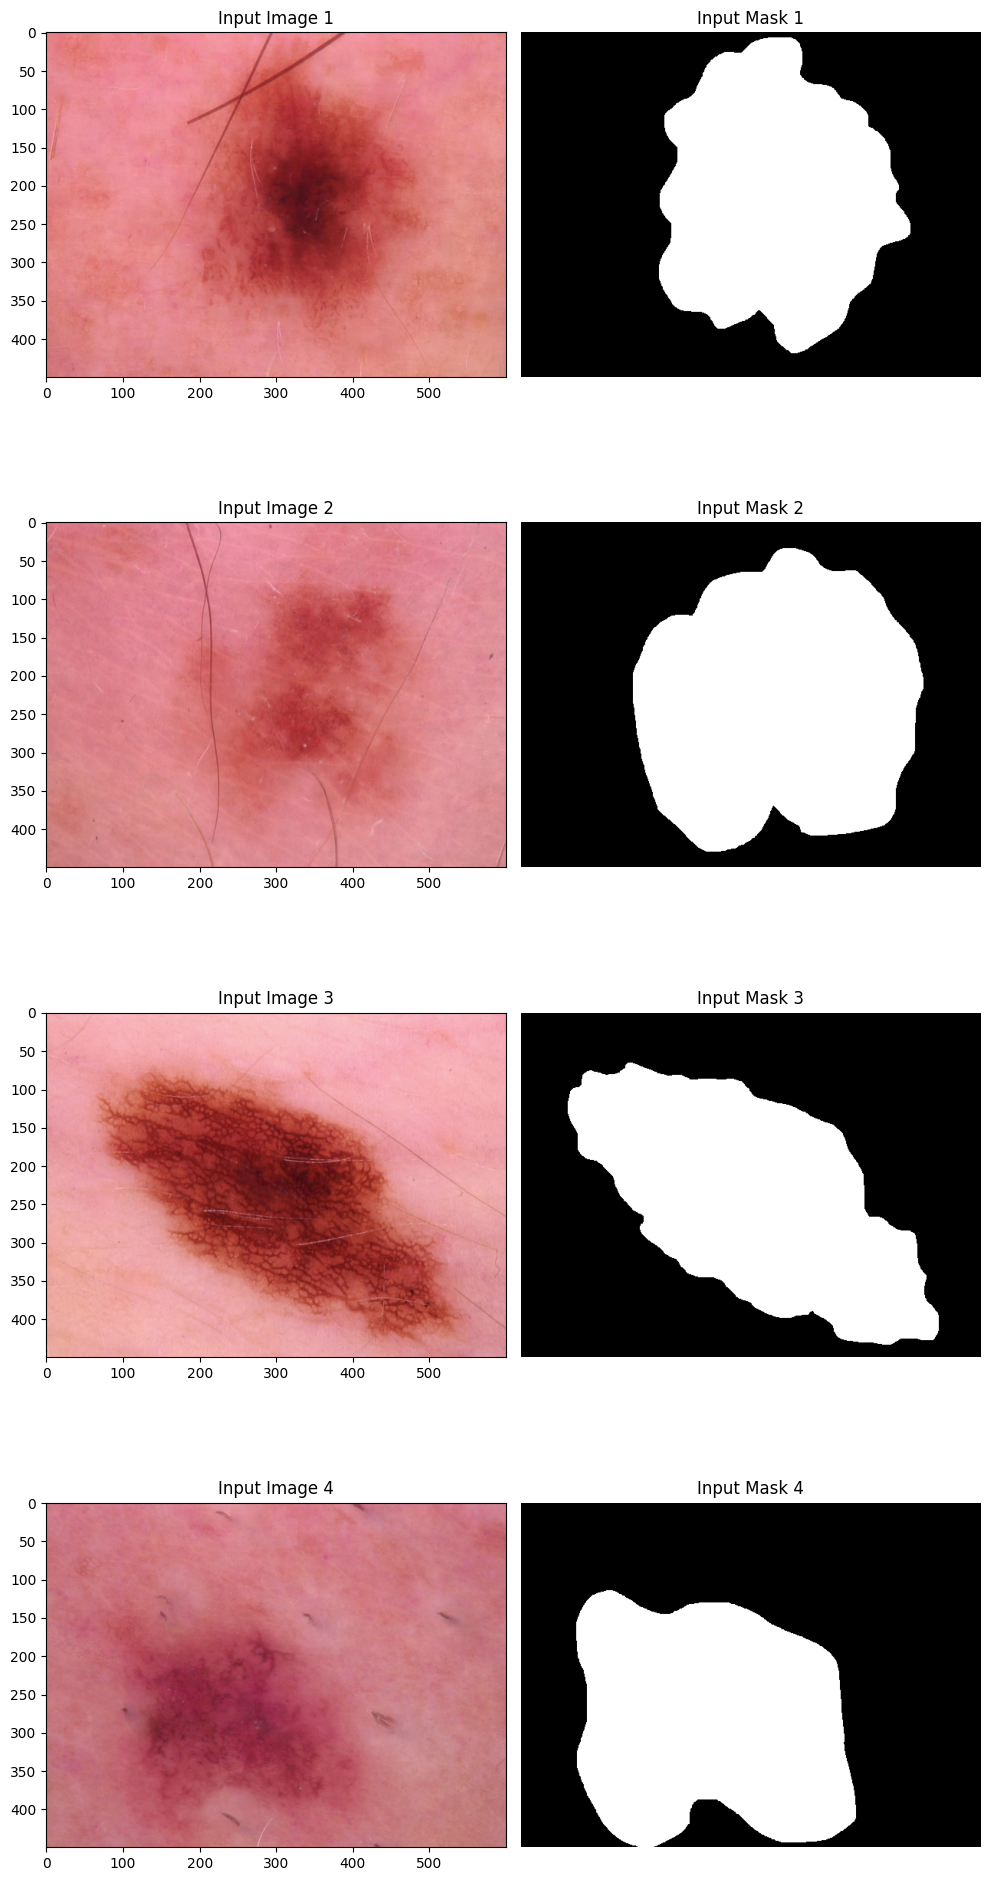

In [167]:

# Path to the dataset directory
dataset_dir = "dataset/"

# Path to the input images and masks directories
input_images_dir = os.path.join(dataset_dir, "input_images/")
input_masks_dir = os.path.join(dataset_dir, "input_images_mask/")

# Get the list of files in the input images directory
input_image_files = os.listdir(input_images_dir)[:4]

# Get the corresponding mask file names
input_mask_files = [file.replace(".jpg", "_segmentation.png") for file in input_image_files]

# Display the images and masks
fig, axes = plt.subplots(4, 2, figsize=(10, 20))

for i, (input_image_file, input_mask_file) in enumerate(zip(input_image_files, input_mask_files)):
    # Load and display the input image
    input_image_path = os.path.join(input_images_dir, input_image_file)
    input_image = plt.imread(input_image_path)
    axes[i, 0].imshow(input_image)
    axes[i, 0].axis('on')
    axes[i, 0].set_title(f"Input Image {i+1}")

    # Load and display the input mask
    input_mask_path = os.path.join(input_masks_dir, input_mask_file)
    input_mask = plt.imread(input_mask_path)
    axes[i, 1].imshow(input_mask, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Input Mask {i+1}")

plt.tight_layout()
plt.show()


C:\Users\SUVROJIT\AppData\Local\Temp\ipykernel_16032\937829365.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


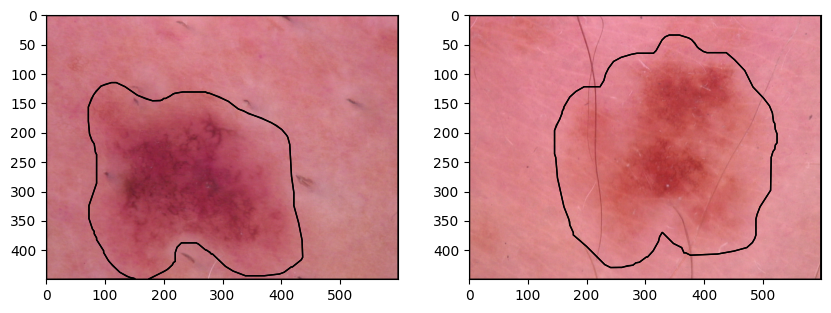

In [161]:
import os
import random
import json
# import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def display_images_with_coco_annotations(image_paths, annotations, display_type='both', colors=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    # fig, axs = plt.subplots(1,1,1)
    
    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax.imshow(image)
        ax.axis('on')  # Turn off the axes

        # Define a default color map if none is provided
        if colors is None:
            colors = plt.cm.get_cmap('tab10')

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']
        
        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]
        
        for ann in img_annotations:
            category_id = ann['category_id']
            color = colors(category_id % 10)
            
            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='black', facecolor='none')
                ax.add_patch(rect)
            
            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor='black', fill=False)
                    ax.add_patch(polygon)

    # plt.tight_layout()
    # plt.show()

# Load COCO annotations
with open('dataset/output/input_images.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "dataset/input_images/"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'
display_images_with_coco_annotations(random_image_files, annotations, display_type)



In [163]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize_coco_annotations(image_paths, annotations, save_dir, display_type='both', colors=None):
    os.makedirs(save_dir, exist_ok=True)

    for img_path in image_paths:
        image = cv2.imread(img_path)
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        for ann in img_annotations:
            category_id = ann['category_id']
            color = colors(category_id % 10) if colors else (0, 0, 0)  # Default color if not specified

            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), color, 2)

            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((int(len(seg)/2), 2)).astype(np.int32)
                    cv2.polylines(image, [poly], isClosed=True, color=color, thickness=2)

        save_path = os.path.join(save_dir, img_filename)
        cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        print(f"Annotated image saved at: {save_path}")

# Load COCO annotations
with open('dataset\output\input_images.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "dataset\input_images"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]

# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'

# Define save directory
save_dir = 'dataset\\negative_masked_images'

# Call the function to visualize and save annotated images
visualize_coco_annotations(all_image_files, annotations, save_dir, display_type)

Annotated image saved at: dataset\negative_masked_images\ISIC_0024306.jpg
Annotated image saved at: dataset\negative_masked_images\ISIC_0024307.jpg
Annotated image saved at: dataset\negative_masked_images\ISIC_0024308.jpg
Annotated image saved at: dataset\negative_masked_images\ISIC_0024309.jpg
Annotated image saved at: dataset\negative_masked_images\ISIC_0024310.jpg


In [172]:
def visualize_coco_annotations(image_paths, annotations, save_dir, display_type='both', colors=None):
    os.makedirs(save_dir, exist_ok=True)

    for img_path in image_paths:
        image = cv2.imread(img_path)
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        for ann in img_annotations:
            category_id = ann['category_id']
            color = colors(category_id % 10) if colors else (0, 0, 0)  # Default color if not specified

            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), color, 2)

            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((int(len(seg)/2), 2)).astype(np.int32)
                    cv2.polylines(image, [poly], isClosed=True, color=color, thickness=2)

        # Convert BGR image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Swap blue and red channels
        image_rgb[:, :, [0, 2]] = image_rgb[:, :, [2, 0]]

        save_path = os.path.join(save_dir, img_filename)
        cv2.imwrite(save_path, image_rgb)
        print(f"Annotated image saved at: {save_path}")

# Load COCO annotations
with open('dataset\output\input_images.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "dataset\input_images"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]

# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'

# Define save directory
save_dir = 'dataset\masked_images'

# Call the function to visualize and save annotated images
visualize_coco_annotations(all_image_files, annotations, save_dir, display_type)


Annotated image saved at: dataset\masked_images\ISIC_0024306.jpg
Annotated image saved at: dataset\masked_images\ISIC_0024307.jpg
Annotated image saved at: dataset\masked_images\ISIC_0024308.jpg
Annotated image saved at: dataset\masked_images\ISIC_0024309.jpg
Annotated image saved at: dataset\masked_images\ISIC_0024310.jpg


In [182]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageFilter
import shutil

# Path to the dataset folder
dataset_path = 'dataset/masked_images/'

# Output folder for the augmented images
output_folder = 'output/'

# Number of times to increase the dataset size
multiplier = 3

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Get the list of all image files in the dataset folder
image_files = [f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]

# Augment images and apply filters
for image_file in image_files:
    # Load the image
    img = Image.open(os.path.join(dataset_path, image_file))

    # Convert the image to a numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Reshape the image to (1, height, width, channels) for the datagen.flow() method
    img_array = img_array.reshape((1,) + img_array.shape)

    # Generate augmented images
    augmented_images = datagen.flow(img_array, batch_size=1)

    # Apply filters to the augmented images
    for i in range(multiplier):
        # Get the augmented image
        augmented_image = next(augmented_images)[0]

        # Convert the augmented image back to a PIL image
        augmented_image = Image.fromarray(augmented_image.astype('uint8'))

        # Apply different filters
        augmented_image_filtered1 = augmented_image.filter(ImageFilter.BLUR)
        augmented_image_filtered2 = augmented_image.filter(ImageFilter.CONTOUR)
        augmented_image_filtered3 = augmented_image.filter(ImageFilter.EMBOSS)

        # Save the filtered images to the output folder
        augmented_image_filtered1.save(os.path.join(output_folder, f'{image_file[:-4]}_filtered1_{i}.png'))
        augmented_image_filtered2.save(os.path.join(output_folder, f'{image_file[:-4]}_filtered2_{i}.png'))
        augmented_image_filtered3.save(os.path.join(output_folder, f'{image_file[:-4]}_filtered3_{i}.png'))

# Print a message when the process is complete
print(f"Augmented images with filters saved to {output_folder}")


Augmented images with filters saved to output/


In [181]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Path to the dataset folder
dataset_path = 'dataset/masked_images/'

# Output folder for the augmented images
output_folder = 'output/'

# Number of times to increase the dataset size
multiplier = 3

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    rotation_range=10,
    zoom_range=(0.0, 0.1),
    shear_range=10,
    channel_shift_range=10,
    rescale=1./255
)

# Get the list of all image files in the dataset folder
image_files = [f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]

# Augment images
for image_file in image_files:
    # Load the image
    img = Image.open(os.path.join(dataset_path, image_file))

    # Convert the image to a numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Reshape the image to (1, height, width, channels) for the datagen.flow() method
    img_array = img_array.reshape((1,) + img_array.shape)

    # Generate augmented images
    augmented_images = datagen.flow(img_array, batch_size=1)

    # Save the augmented images to the output folder
    for i in range(multiplier):
        augmented_image = next(augmented_images)[0]
        augmented_image = Image.fromarray((augmented_image * 255).astype('uint8'))
        augmented_image.save(os.path.join(output_folder, f'{image_file[:-4]}_augmented_{i}.png'))

# Print a message when the process is complete
print(f"Augmented images saved to {output_folder}")


Augmented images saved to output/
